# Assignment 8

In this assignment we'll estimate a regression model using the horseshoe prior. We're going to analyze [some data I found on Kaggle](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction) and try to predict the price of flights. 

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. Your work will be manually graded by our TA. 


### Data Cleaning

I will make some transformations to prepare this data set for regression:

 - create dummy columns for the categorical data,
 - transform price to log price,
 - create interaction terms.

Note that my decision to disregard certain columns, or interactions or transformations is a reflection of my prior knowledge. Ommitting a column is equivalent to setting a very informative prior for that hypothetical column's weight (centered at $0$). Commonly performed procedures have a place in the Bayesian philosophy, and are not as ad hoc as they seem to be in the frequentist domain!

In [123]:
import pandas as pd
import numpy as np
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import math

In [2]:
flights = pd.read_csv("Clean_Dataset.csv", index_col=0)
flights.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [3]:
# change dependent variabe by taking the logarithm
flights['log_price'] = np.log(flights['price'])
flights = flights.drop('price', axis=1)

In [4]:
# create airlines dummies
# baseline is "other" (AirAsia","GO_FIRST", or "SpiceJet")
airline_dummies = pd.get_dummies(flights['airline']).astype(float)
airline_dummies = airline_dummies.drop(["AirAsia","GO_FIRST","SpiceJet"],axis=1)

In [5]:
# one dummy for business class (baseline is economy)
class_dummies = pd.get_dummies(flights['class']).astype(float)
class_dummies = class_dummies['Business']
class_dummies.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Business, dtype: float64

In [6]:
# create predictor matrix
X = pd.concat([flights[['duration', 'days_left']], airline_dummies, class_dummies], axis=1)
X.head()

,duration,days_left,Air_India,Indigo,Vistara,Business
0,2.17,1,0.0,0.0,0.0,0.0
1,2.33,1,0.0,0.0,0.0,0.0
2,2.17,1,0.0,0.0,0.0,0.0
3,2.25,1,0.0,0.0,1.0,0.0
4,2.33,1,0.0,0.0,1.0,0.0


## Problem 1: Running MCMC

There's a lot of data here, which means running MCMC the way we typically do is going to take a long time. Let's start by only using some of the rows. Feel free to adjust the variable below to keep as many rows as you want--the lower the number the faster your code. 

Note that your inferences will be compromised because we are throwing away data, in a sense, but we need to keep this data manageable, especially while we're getting our code ready for prime time. 

Do not run a variational algorithm yet! We'll do that in the next problem!

Note that if you keep too few rows, there's a chance that a dummy column will have all $1$s or all $0$s. This is a problem because it will introduce collinearity. Also, it will make those predictors look unimportant even when they are!

We shuffle the rows before selecting some of them to reduce the chances this happens. We also check to make sure indicator columns are not all $1$ or all $0$. If they were, the column average would be $1$ or $0$ exactly 

In [7]:
num_rows_to_keep = 100 # change me if you want!
row_indexes = np.arange(0,X.shape[0])
np.random.shuffle(row_indexes)
rows_to_keep = row_indexes[0:num_rows_to_keep]
baby_X = X.iloc[rows_to_keep,]
baby_y = flights.loc[rows_to_keep,'log_price']
baby_X.mean(axis=0)

duration     13.0118
days_left    27.3500
Air_India     0.2700
Indigo        0.1500
Vistara       0.4600
Business      0.3300
dtype: float64

1.

Write `.stan` file and estimate your model using the NUTS algorithm.

In [30]:
model_code = os.path.join('.', 'mlr_horseshoe.stan')
model = CmdStanModel(stan_file=model_code)

19:17:37 - cmdstanpy - INFO - compiling stan file /tmp/tmpx3jt9qai/tmpodcbflzu.stan to exe file /bml24/Assignment 8/mlr_horseshoe
19:17:58 - cmdstanpy - INFO - compiled model executable: /bml24/Assignment 8/mlr_horseshoe


In [31]:
our_data = {'N' : num_rows_to_keep, 'K': 6, 'X': baby_X, 'y':baby_y}
fit = model.sample(data = our_data)

19:18:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:18:17 - cmdstanpy - INFO - CmdStan done processing.
19:18:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter[1] is 0, but must be positive! (in 'mlr_horseshoe.stan', line 23, column 2 to column 33)
Consider re-running with show_console=True if the above output is unclear!
19:18:17 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 23 divergent transitions (2.3%)
	Chain 2 had 24 divergent transitions (2.4%)
	Chain 3 had 10 divergent transitions (1.0%)
	Chain 4 had 22 divergent transitions (2.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


2.

Write code to check that **all** of your $\hat{R}$ convergence diagnostics. Use a threshold of $1.01$. Be honest!

You might see some warnings about "divergent transitions." This means that the geometry of the posterior is relatively complicated, and the NUTS algorithm isn't having as easy of a time with it. This is common with the horseshoe prior.

The warnings can be addressed by 

 - re-tuning the NUTS algorithm (not discussed),
 - writing the horseshoe prior differently in our `.stan` file (not discussed), or
 - **just running the NUTS sampler for longer.** 

Indeed, $\hat{R}$ will still be our metric to tell us if we didn't run our chain for long enough. If all of them are below $1.01$, then you can ignore the warnings. 


In [88]:
fit.summary().iloc[0:9]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-38.122100,0.075940,2.812380,-43.213400,-37.761600,-34.174400,1371.530000,1769.710000,1.002170
alpha,8.727430,0.003258,0.134920,8.507410,8.728950,8.946360,1714.830000,2212.680000,1.001040
beta[1],0.004438,0.000098,0.004990,-0.003191,0.004066,0.012983,2582.060000,3331.690000,0.999685
beta[2],-0.018238,0.000045,0.002453,-0.022220,-0.018277,-0.014298,2997.670000,3867.960000,0.999843
beta[3],0.409049,0.003429,0.133388,0.180979,0.414921,0.617173,1513.360000,1952.720000,1.003070
beta[4],0.133984,0.003327,0.125314,-0.044296,0.127100,0.354077,1418.810000,1830.720000,1.001010
beta[5],0.576292,0.003145,0.124758,0.363763,0.579423,0.781558,1573.160000,2029.890000,1.002240
beta[6],2.040920,0.001496,0.080865,1.905710,2.041220,2.171960,2921.580000,3769.780000,0.999772
sigma,0.331107,0.000514,0.024760,0.294196,0.329023,0.374252,2316.307539,2988.783921,1.001591


All the $\hat{R}$s are indeed less than 1.01 indicating the model is good to use and I can ignore the warnings.

3.

What is the estimate of the intercept? What is its interpretation? What is a credible interval for this quantity? Provide an accompanying histogram.

The estimate for the intercept is 8.73493. This means we expect a ticket to cost $6216.30 (e^8.73493). The credible interval is (8.51778, 8.95713). Below is the histogram for the intercept.

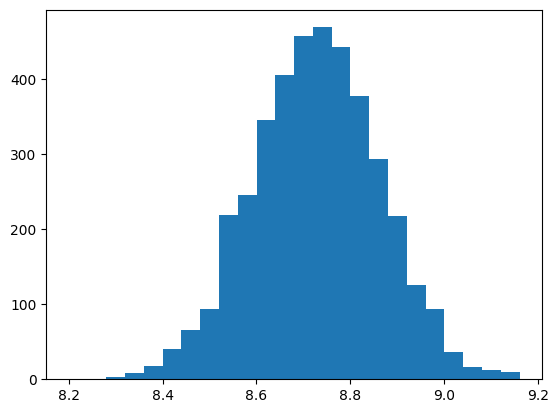

In [135]:
plt.hist(fit.draws_pd()['alpha'], bins=24)
plt.show()

4.

What is the estimate of the standard deviation of the noise? What is its interpretation? What is a credible interval for this quantity? Provide an accompanying histogram.

The estimate for the standard deviation of the noise is 0.330693. This means the values are dispersed around their mean value by 0.33. This seems like a low value given the constext which means there is not a lot of variation in the values. The credible interval is (0.293442, 0.374061). Below is the histogram for sigma.

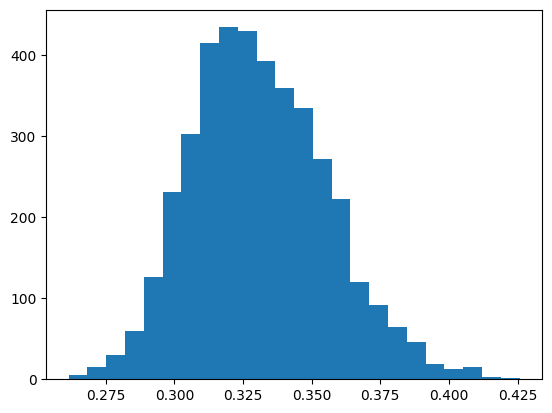

In [137]:
plt.hist(fit.draws_pd()['sigma'], bins=24)
plt.show()

5.

Use a scatterplot matrix and some credible intervals to visualize the $\beta$ weight samples. Do any of the predictors look unimportant? Do any of them look correlated?



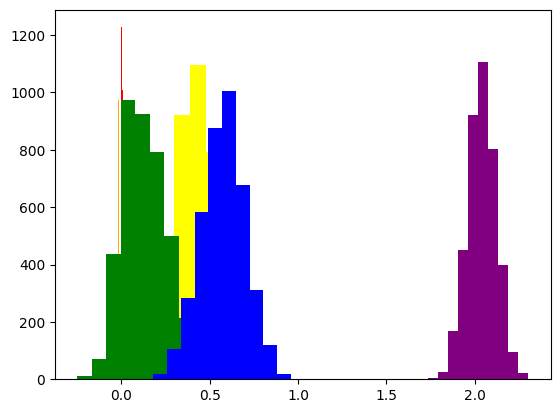

In [73]:
plt.hist(fit.draws_pd()['beta[1]'], color='red')
plt.hist(fit.draws_pd()['beta[2]'], color='orange')
plt.hist(fit.draws_pd()['beta[3]'], color='yellow')
plt.hist(fit.draws_pd()['beta[4]'], color='green')
plt.hist(fit.draws_pd()['beta[5]'], color='blue')
plt.hist(fit.draws_pd()['beta[6]'], color='purple')
plt.show()

Beta[1] and beta[2] appear to be unimportant since their menas are practically 0 with little width. Beta[3] and beta[5] look like they could be correlated since their peaks are around the same, so they warrant a closer look.

6.

Pick an arbitrary observation number (call it $i$). This corresponds to the index of a row in your predictor matrix. 

Plot the posterior predictions for $\tilde{y}_i$ for this particular predictor. There are many simulations for this one quantity.

Compare them to the actual dependent observation at that row $y_i$. Ideally your $y_i$ should be in the center of the histogram of predictions. Overlay a vertical line to show where this $y_i$ is.

Once you're convinced you have working code, copy/paste it into a function definition so that you can quickly switch between different predictions. 

NB: `stan` indexes start at $1$, while Python indexes start at $0$!

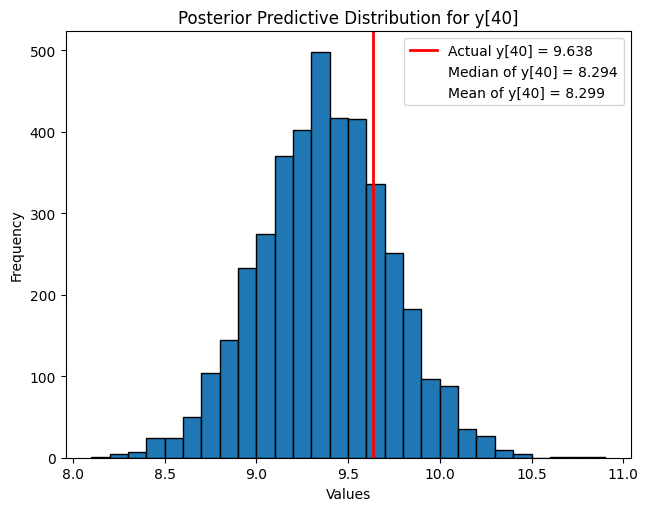

In [128]:
def plot_posterior_predictive_one_predictor(arb_row):
    bins = np.arange((math.floor(fit.draws_pd()[f'y_tilde[{arb_row}]'].min() * 10) / 10), (math.ceil(fit.draws_pd()[f'y_tilde[{arb_row}]'].max() * 10) / 10), 0.1)
    plt.hist(fit.draws_pd()[f'y_tilde[{arb_row}]'], bins=bins, edgecolor='black')
    plt.axvline(x=baby_y.iloc[arb_row-1], color='red', linewidth=2, label=f"Actual y[{arb_row}] = {baby_y.iloc[arb_row-1].round(3)}")
    plt.plot([],[], ' ', label=f"Median of y[{arb_row}] = {fit.summary().loc['y_tilde[1]', '50%'].round(3)}")
    plt.plot([],[], ' ', label=f"Mean of y[{arb_row}] = {fit.summary().loc['y_tilde[1]', 'Mean'].round(3)}")
    plt.legend()
    plt.tight_layout()
    plt.title("Posterior Predictive Distribution for y[{}]".format(arb_row))
    plt.ylabel("Frequency")
    plt.xlabel("Values")
    plt.show()
plot_posterior_predictive_one_predictor(40)

## Problem 2: Running Variational Inference Algorithms

There's a lot of data here, which means we had to ignore it to quickly run MCMC, especially while we were prototyping. 

Use a variational inference algorithm on the full data set now. Do not recompile your stan model. You don't need to. This took a few minutes on my machine.


In [130]:
Y = flights['log_price']
full_data = {'N' : flights.shape[0], 'K': 6, 'X': X, 'y':Y}
fitp = model.pathfinder(full_data)

19:47:02 - cmdstanpy - INFO - Chain [1] start processing
19:48:59 - cmdstanpy - INFO - Chain [1] done processing


In [131]:
param_namesp = fitp.column_names
posteriorp_df = pd.DataFrame(fitp.draws(), columns=param_namesp)
posteriorp_df

,lp_approx__,lp__,alpha,beta[1],beta[2],beta[3],beta[4],beta[5],beta[6],sigma,...,y_tilde[300144],y_tilde[300145],y_tilde[300146],y_tilde[300147],y_tilde[300148],y_tilde[300149],y_tilde[300150],y_tilde[300151],y_tilde[300152],y_tilde[300153]
0,97.1520,-129079.0,8.68082,0.015931,-0.014483,0.190490,0.030327,0.346336,2.01638,0.372280,...,10.48200,10.4532,10.27310,9.79224,10.4134,10.69020,9.99791,10.77950,10.31420,10.76790
1,97.1520,-129079.0,8.68082,0.015931,-0.014483,0.190490,0.030327,0.346336,2.01638,0.372280,...,10.48200,10.4532,10.27310,9.79224,10.4134,10.69020,9.99791,10.77950,10.31420,10.76790
2,93.8346,-129081.0,8.68007,0.016055,-0.014463,0.187544,0.032738,0.344432,2.01588,0.370874,...,10.25520,11.1740,10.23000,10.57600,10.2524,11.05380,10.30180,10.13560,10.62390,10.72290
3,97.1285,-129079.0,8.68148,0.016057,-0.014529,0.189961,0.033365,0.345360,2.01567,0.372232,...,10.14860,10.2934,10.82110,10.52770,10.2885,10.39570,10.98810,9.78735,10.41950,10.72150
4,100.8110,-129080.0,8.67964,0.016065,-0.014469,0.189467,0.035701,0.344574,2.01499,0.372339,...,9.94036,10.9113,10.22280,10.60000,11.5061,10.67330,10.38050,11.02300,10.89270,9.86323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,95.3405,-129079.0,8.67786,0.016013,-0.014424,0.190108,0.035603,0.344330,2.01784,0.371963,...,10.33280,10.3516,10.82330,10.67950,10.5418,10.29530,9.88560,10.45970,10.99290,10.41580
996,95.8381,-129079.0,8.67937,0.015969,-0.014441,0.191127,0.030845,0.345486,2.01745,0.372302,...,10.17000,10.5709,10.90300,10.09300,10.2576,9.89986,10.11910,10.50170,9.73015,10.89590
997,96.3380,-129080.0,8.67960,0.016087,-0.014396,0.187081,0.029920,0.341219,2.01681,0.372193,...,10.66940,10.6220,9.90362,10.63020,10.4906,10.48950,10.71190,10.19250,9.90167,10.17010
998,97.1285,-129079.0,8.68148,0.016057,-0.014529,0.189961,0.033365,0.345360,2.01567,0.372232,...,10.14860,10.2934,10.82110,10.52770,10.2885,10.39570,10.98810,9.78735,10.41950,10.72150


1.

Plot a histogram for the alpha parameter. Does it look the same as the MCMC output? 

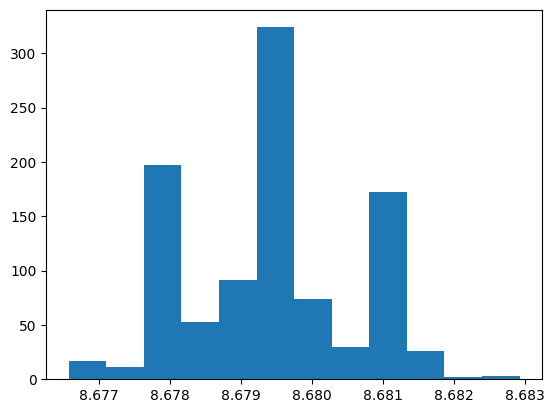

In [140]:
plt.hist(posteriorp_df['alpha'], bins=12)
plt.show()

This does not look like the MCMC distribution for alpha. That distribution was approximately normal, this one has more than one peak. The peaks (the primary one here and the MCMC) are about the same position. This distribution looks decently symmetric, thought I've run this multiple times and have had some look more skewed right than symmetric.

2.

Plot the same scatterplot matrix for the betas? How does it look compared to the full MCMC output?

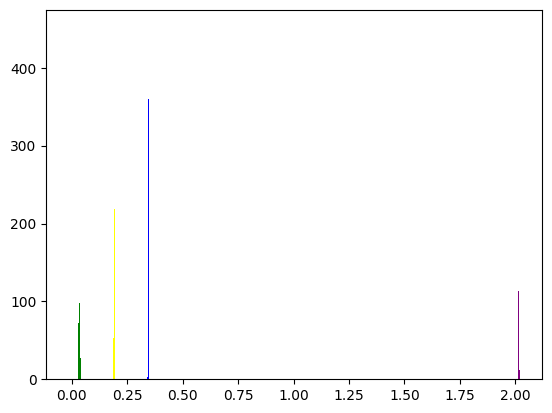

In [133]:
plt.hist(posteriorp_df['beta[1]'], color='red')
plt.hist(posteriorp_df['beta[2]'], color='orange')
plt.hist(posteriorp_df['beta[3]'], color='yellow')
plt.hist(posteriorp_df['beta[4]'], color='green')
plt.hist(posteriorp_df['beta[5]'], color='blue')
plt.hist(posteriorp_df['beta[6]'], color='purple')
plt.show()

In [142]:
summaryp = posteriorp_df.describe(percentiles=[0.05, 0.95]).T
summaryp[['mean', '5%', '95%']].iloc[0:9]

,mean,5%,95%
lp_approx__,95.933625,91.246200,100.255650
lp__,-129079.907000,-129083.000000,-129079.000000
alpha,8.679350,8.677860,8.680961
beta[1],0.015976,0.015815,0.016067
beta[2],-0.014433,-0.014488,-0.014381
beta[3],0.190595,0.187544,0.192572
beta[4],0.033076,0.030317,0.035603
beta[5],0.345010,0.342561,0.347765
beta[6],2.016879,2.014430,2.017840


The plot for the betas looks very different. Beta[1] and beta[2] don't even show up. The rest are very spikey - they have almost no width to them. I ran a credible interval for them just to see and all the intervals are crazy small, so it makes sense. Beta[4] is also very close to 0 now.

## Problem 3: MAP Estimates

It still might be a bit slow for you, even if you are just running a variational algorithm. If you would like to do as the frequentists do--just optimize a function instead of trying to find the function itself--you can just find the MAP estimate:

$$
\text{argmax}_\theta \pi(\theta \mid y)
$$

At least this way we get the benefit of the prior. This is the fastest out of the three approaches so far because there is no attempt to find the posterior's function--just its mode.

1.

Use your model's `.optimize()` function to display the point estimates for your parameters.

In [33]:
est = model.optimize(full_data)

19:18:59 - cmdstanpy - INFO - Chain [1] start processing
19:19:05 - cmdstanpy - INFO - Chain [1] done processing


In [153]:
betas = np.array(['beta_1', 'beta_2', 'beta_3', 'beta_4', 'beta_5','beta_6'])
opt = pd.DataFrame(est.beta, betas)
opt = opt.rename(columns={0: 'MAP Estimate'})
opt

,MAP Estimate
beta_1,0.015990
beta_2,-0.014428
beta_3,0.191772
beta_4,0.033655
beta_5,0.346609
beta_6,2.015590
